# A simple algorithm for generating streamflow networks for grid‐based, macroscale hydrological models
https://doi.org/10.1002/(SICI)1099-1085(19990615)13:8%3C1269::AID-HYP806%3E3.0.CO;2-R

A simple algorithm for generating streamflow networks for macroscale hydrological models (MHMs) from digital elevation models (DEMs) is presented. Typically these hydrological models are grid based, with the simulated runoff produced within each cell routed through a stream network which connects the centers of cells in the direction of the major streams. Construction of such stream networks is a time consuming task, which has generally been done by hand with the aid of maps. Results indicate that the algorithm works satisfactorily in areas of both high and low relief, and for a wide range of model cell resolutions, although some manual adjustments may be necessary.

In [276]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from rasterio import mask
from tqdm import notebook

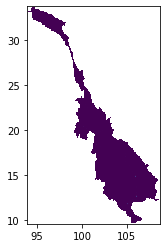

<AxesSubplot:>

In [207]:
flowacc_path = '../data_nongit/mekong_flowaccumulation.tif'
flowacc_rast = rio.open(flowacc_path)

flowacc = flowacc_rast.read(1)
show(flowacc_rast)

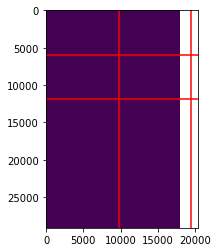

In [203]:
# plt.imshow(flowacc == flowacc.max())   # As predicted, the highest accumulation pixel is at the edge.
# yleft, yright = flowacc.shape[0]/3, flowacc.shape[0]*2/3
# xup, xbot = flowacc.shape[1]/3, flowacc.shape[1]*2/3
# plt.axvline(yleft, color='red')
# plt.axvline(yright, color='red')
# plt.axhline(xup, color='red')
# plt.axhline(xbot, color='red')

In [269]:
class GridCell:
    def __init__(self, geom, rast):
        """
        geom is a geopandas object, single polygon which can be used to clip rasters
        rast is a rasterio raster object
        """
        self._geom = geom["geometry"]
        self._id = geom.name
        
        self.src = rast

        self.clipped = self.clip()
        
        self.edges = (0, self.clipped.shape[0]-1, self.clipped.shape[1]-1)
        
        self.exit = self.where()
        
        
    def clip(self, write=False, savepath=None):
        masked_band, masked_transform = mask.mask(self.src, [self._geom], crop=True)

        return masked_band[0]
    
    def where(self):
        wh = np.where(self.clipped == self.clipped.max())
        return wh[0][0], wh[1][0]
    
    def clean(self):
        os.remove(self.clipped)
    
    def clean_exit(self):
        return (self.exit[0] in self.edges) or (self.exit[1] in self.edges)

class Basin:
    def __init__(self, path):
        self._path = path
        
        self._gdf = gpd.read_file(path)
        print(self._gdf.head())
        
    def __str__(self):
        return f"Basin<{os.path.split(self._path)[-1]} : {self._gdf.shape[0]} features>"
    
    def __repr__(self):
        return self.__str__()

In [279]:
exits = {
    'i': [],
    'x': [],
    'y': [],
    'clean_exit': []
}

with notebook.tqdm(total=gdf.shape[0]) as pbar:
    for i in range(gdf.shape[0]):
        gc = GridCell(gdf.iloc[i, :], flowacc_rast)
        exits['i'].append(i)
        exits['x'].append(gc.exit[0])
        exits['y'].append(gc.exit[1])
        exits['clean_exit'].append(gc.clean_exit())
        pbar.update(1)
        pbar.set_description(f'{i:05}: ({gc.exit[0]:03}, {gc.exit[1]:03}): {gc.clean_exit()}')

  0%|          | 0/18217 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [280]:
import pandas as pd

df = pd.DataFrame(exits)
df.head()

,i,x,y,clean_exit
0,0,70,74,True
1,1,68,44,False
2,2,31,0,True
3,3,49,57,False
4,4,44,45,False


In [283]:
df.groupby('clean_exit').count()

,i,x,y
clean_exit,,,
False,337,337,337
True,17880,17880,17880
